In [1]:
import sys
sys.path.append('../src')
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl
tauE, tauI, dt = 30, 10, 1

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
syl = rng.multivariate_normal(np.zeros(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

(3, 600)


/var/folders/bg/43fgzqj14377b2s2s0m5wfym0000gn/T/ipykernel_9774/2737249185.py:5: RuntimeWarning: divide by zero encountered in matmul
  syl = rng.multivariate_normal(np.zeros(NE), syl_cov, size=N_syl)
/var/folders/bg/43fgzqj14377b2s2s0m5wfym0000gn/T/ipykernel_9774/2737249185.py:5: RuntimeWarning: overflow encountered in matmul
  syl = rng.multivariate_normal(np.zeros(NE), syl_cov, size=N_syl)
/var/folders/bg/43fgzqj14377b2s2s0m5wfym0000gn/T/ipykernel_9774/2737249185.py:5: RuntimeWarning: invalid value encountered in matmul
  syl = rng.multivariate_normal(np.zeros(NE), syl_cov, size=N_syl)


In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [8]:
gen = lognormal_gen
c = 0.5

srKEc, srKIc = np.sqrt(NE*c), np.sqrt(NI*c)
JEE0, JEI0, JIE0, JII0 = np.array([1/srKEc, 1.7/srKIc, 1.02/srKEc, 1.5/srKIc]) / 10
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True)

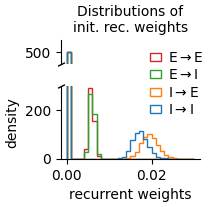

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(2, 2), height_ratios=[1, 3], constrained_layout=False)
fig.subplots_adjust(hspace=0.05)
if issparse(JEE):
    hist = [_.toarray().flatten() for _ in [JII, JEI, JIE, JEE]]
else:
    hist = [_.flatten() for _ in [JII, JEI, JIE, JEE]] 
for i in range(2):
    ax[i].hist(hist, bins=30, density=True, histtype='step', range=(0, 0.03), lw=1.5,
               label=[r'I$\to$I', r'I$\to$E', r'E$\to$I', r'E$\to$E'])
ax[0].set(ylim=[400, 600], yticks=[500], xticks=[])
ax[1].set(ylim=[0, 300], yticks=[0, 200], ylabel='density', xlabel='recurrent weights')
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0], [0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0], [1], transform=ax[1].transAxes, **kwargs)
ax[0].set_title('Distributions of\ninit. rec. weights', fontsize=10)
ax[1].legend(bbox_to_anchor=(0.55, 0.4), ncols=1, frameon=False,
             handlelength=0.8, handletextpad=0.5)
fig.tight_layout(pad=0.1)
fig.savefig('../svg/J_dist.svg')

In [10]:
rEmax, rImax, thE, thI, sE, sI = 100, 100, 0, 0, 2, 2

In [11]:
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05
w_inh_E2E = w0_mean_E2E*cW_E2E*0

net = EINet(NE, NI, N_HVC, w0_mean_E2E, (rEmax, thE, sE), (rImax, thI, sI), tauE, tauI, 
            JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
            w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

100%|███████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 5561.87it/s]


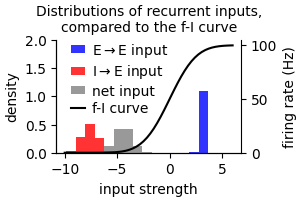

In [12]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
aux = [np.zeros_like(rH[:500])+rH[:500].mean(axis=1)[:,None], 
       np.zeros_like(aud[:500])+aud[:500].mean(axis=1)[:,None]]
_ = net.sim(hE0, hI0, *aux, [], 500, dt, 0)
rE, rI, _, _, hE = _
ee_in = (net.JEE @ rE.T).T.mean(axis=0)
ei_in = (net.JEI @ rI.T).T.mean(axis=0)
_ = np.linspace(-10, 6)
fig, ax = plt.subplots(1, figsize=(3, 2))
ax = [ax, ax.twinx()]
ax[1].spines.right.set_visible(True)
ax[0].hist([ee_in-ei_in, -ei_in, ee_in], bins=15, density=True, 
           histtype='stepfilled', alpha=0.8, color=['grey', 'r', 'b'],
           label=[r'net input', r'I$\to$E input', r'E$\to$E input'])
ax[0].plot(0, 0, c='k', label='f-I curve')
ax[0].legend(loc=(0.05, 0.28))
ax[1].plot(_, EINet.phi(_, *net.phiE), color='k', zorder=10)
ax[0].set(ylabel='density', xlabel='input strength', ylim=[0, 2])
ax[0].set_title('Distributions of recurrent inputs,\ncompared to the f-I curve', fontsize=10)
ax[1].set(ylim=[0, 105], ylabel='firing rate (Hz)')
fig.savefig('../svg/show_EI_balance.svg', transparent=True)